In [4]:
# Import all packages

import os
os.chdir('/home/scur2012/Thesis/master-thesis/experiments/tmnre')

import numpy as np
import zarr
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import swyft.lightning as sl

import gw_parameters
import importlib
importlib.reload(gw_parameters)


<module 'gw_parameters' from '/gpfs/home3/scur2012/Thesis/master-thesis/experiments/tmnre/gw_parameters.py'>

In [5]:
# Initialise configuration settings

conf = gw_parameters.default_conf
bounds = gw_parameters.limits

In [6]:
# Load swyft-based simulator. 
# This builds the framework for the computational DAG

import peregrine_simulator
importlib.reload(peregrine_simulator)
from peregrine_simulator import Simulator

swyft_simulator = Simulator(conf, bounds)

In [7]:
# Generate ground-truth observation

obs = swyft_simulator.generate_observation()

# Convert observation to swyft type sample

obs_sample = sl.Sample(
    {key: obs[key] for key in ["d_t", "d_f", "d_f_w", "n_t", "n_f", "n_f_w"]}
)

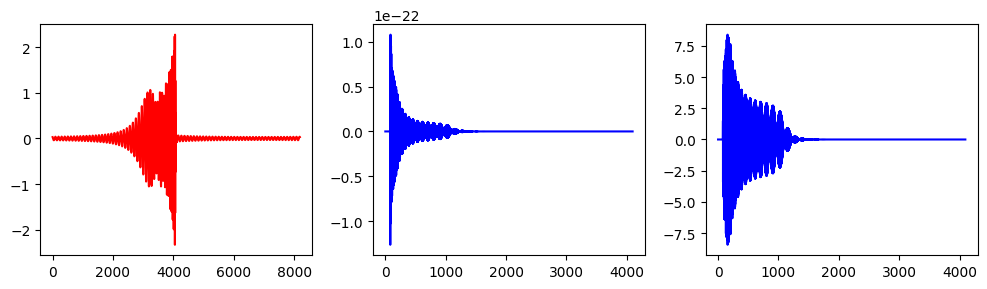

In [15]:
# Plot signal

import matplotlib.pyplot as plt

# Create a figure and two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))  # 1 row, 2 columns, optional figure size

# Plot data on the first subplot
ax1.plot(obs['d_t'][0], 'r-') 
ax2.plot(obs['d_f'][0], 'b-')
ax3.plot(obs['d_f_w'][0], 'b-')
plt.tight_layout()
plt.show()

In [18]:
# Set up the zarr store

zarr_store_dirs = '/scratch-shared/scur2012/peregrine_data/tmnre_experiments'
name_of_run = 'test2'
simulation_store_path = f"{zarr_store_dirs}/{name_of_run}/simulations"

number_of_simulations = 1000
shapes, dtypes = swyft_simulator.get_shapes_and_dtypes()
shapes.pop("n")
dtypes.pop("n")

chunk_size = 1000
zarr_store = sl.ZarrStore(f"{simulation_store_path}")
zarr_store.init(
    N=number_of_simulations, 
    chunk_size=chunk_size, 
    shapes=shapes,
    dtypes=dtypes)

In [28]:
# Generate the random observations and save the data to the zarr store
import multiprocessing

njobs = 8

def populate_zarr_simulation(number_of_simulations):
    zarr_store.simulate(
        sampler=swyft_simulator,
        batch_size=number_of_simulations if number_of_simulations<chunk_size else chunk_size
        max_sims=number_of_simulations,
    )

simulations_per_thread = [len(part) for part in np.array_split(np.arange(number_of_simulations), njobs)]

# Creating a pool of worker processes
with multiprocessing.Pool(njobs) as pool:
    results = pool.map(populate_zarr_simulation, simulations_per_thread)


1000

In [11]:
# Initialise data loader for training network

network_settings = dict(
    min_epochs = 1,
    max_epochs = 10,
    early_stopping = 7,
    learning_rate = 5e-4,
    num_workers = 8,
    training_batch_size = 1,
    validation_batch_size = 1,
    train_split = 0.9,
    val_split = 0.1,
    shuffling = True,
    priors = dict(
        int_priors = conf['priors']['int_priors'],
        ext_priors = conf['priors']['ext_priors'],
    ),
    marginals = (0,1),
    one_d_only = True,
    ifo_list = conf["waveform_params"]["ifo_list"],
)

train_data = zarr_store.get_dataloader(
    num_workers=network_settings['num_workers'],
    batch_size=network_settings['training_batch_size'],
    idx_range=[0, int(network_settings['train_split'] * len(zarr_store.data.z_int))],
    on_after_load_sample=False,
)

val_data = zarr_store.get_dataloader(
    num_workers=network_settings['num_workers'],
    batch_size=network_settings['validation_batch_size'],
    idx_range=[
        int(network_settings['train_split'] * len(zarr_store.data.z_int)),
        len(zarr_store.data.z_int) - 1,
    ],
    on_after_load_sample=None,
)

training_store_path = f"{zarr_store_dirs}/{name_of_run}/training"
round_id = 1

In [12]:
# Set up the pytorch trainer settings

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

lr_monitor = LearningRateMonitor(logging_interval="step")
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=network_settings["early_stopping"],
    verbose=False,
    mode="min",
)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=f"{training_store_path}",
    filename="{epoch}_{val_loss:.2f}_{train_loss:.2f}" + f"_R{round_id}",
    mode="min",
)
logger_tbl = pl_loggers.TensorBoardLogger(
    save_dir=f"{training_store_path}",
    name=f"test_R{round_id}",
    version=None,
    default_hp_metric=False,
)

swyft_trainer = sl.SwyftTrainer(
    accelerator='gpu',
    gpus=1,
    min_epochs=network_settings["min_epochs"],
    max_epochs=network_settings["max_epochs"],
    logger=logger_tbl,
    callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback],
)

/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/scur2012/Thesis/master-thesis/.venv/lib/py ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
import peregrine_network
from peregrine_network import InferenceNetwork

import importlib
importlib.reload(constants)
importlib.reload(peregrine_network)

# Load network model
network = InferenceNetwork(network_settings)

# Fit data to model
# swyft_trainer.fit(network, train_data, val_data)

# Test the network
swyft_trainer.test(network, val_data, "/scratch-shared/scur2012/peregrine_data/tmnre_experiments/test/training/test_R1/version_2/checkpoints/epoch=7-step=8000.ckpt")


/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
You are using a CUDA device ('NVIDIA A100-SXM4-40GB MIG 1g.5gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /scratch-shared/scur2012/peregrine_data/tmnre_experiments/test/training/test_R1/version_2/checkpoints/epoch=7-step=8000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-3c7f8621-d24c-51f3-82e2-1057fe5fe944]
Loaded model weights from checkpoint at /scratch-shared/scur2012/per

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          8.964538551481382e-07
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 8.964538551481382e-07}]

In [14]:
# Generate prior samples for testing the trained model
prior_simulator = Simulator(conf, bounds)
prior_samples = prior_simulator.sample(100_000, targets=["z_total"])

# Run model in inference mode
logratio_data = swyft_trainer.infer( 
    network, 
    obs_sample, 
    prior_samples)

  0%|          | 0/100000 [00:00<?, ?it/s]

You are using a CUDA device ('NVIDIA A100-SXM4-40GB MIG 1g.5gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-3c7f8621-d24c-51f3-82e2-1057fe5fe944]


Predicting: 0it [00:00, ?it/s]

/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [33]:
prior_samples['z_total'][:, 14]

array([-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1], dtype=float32)

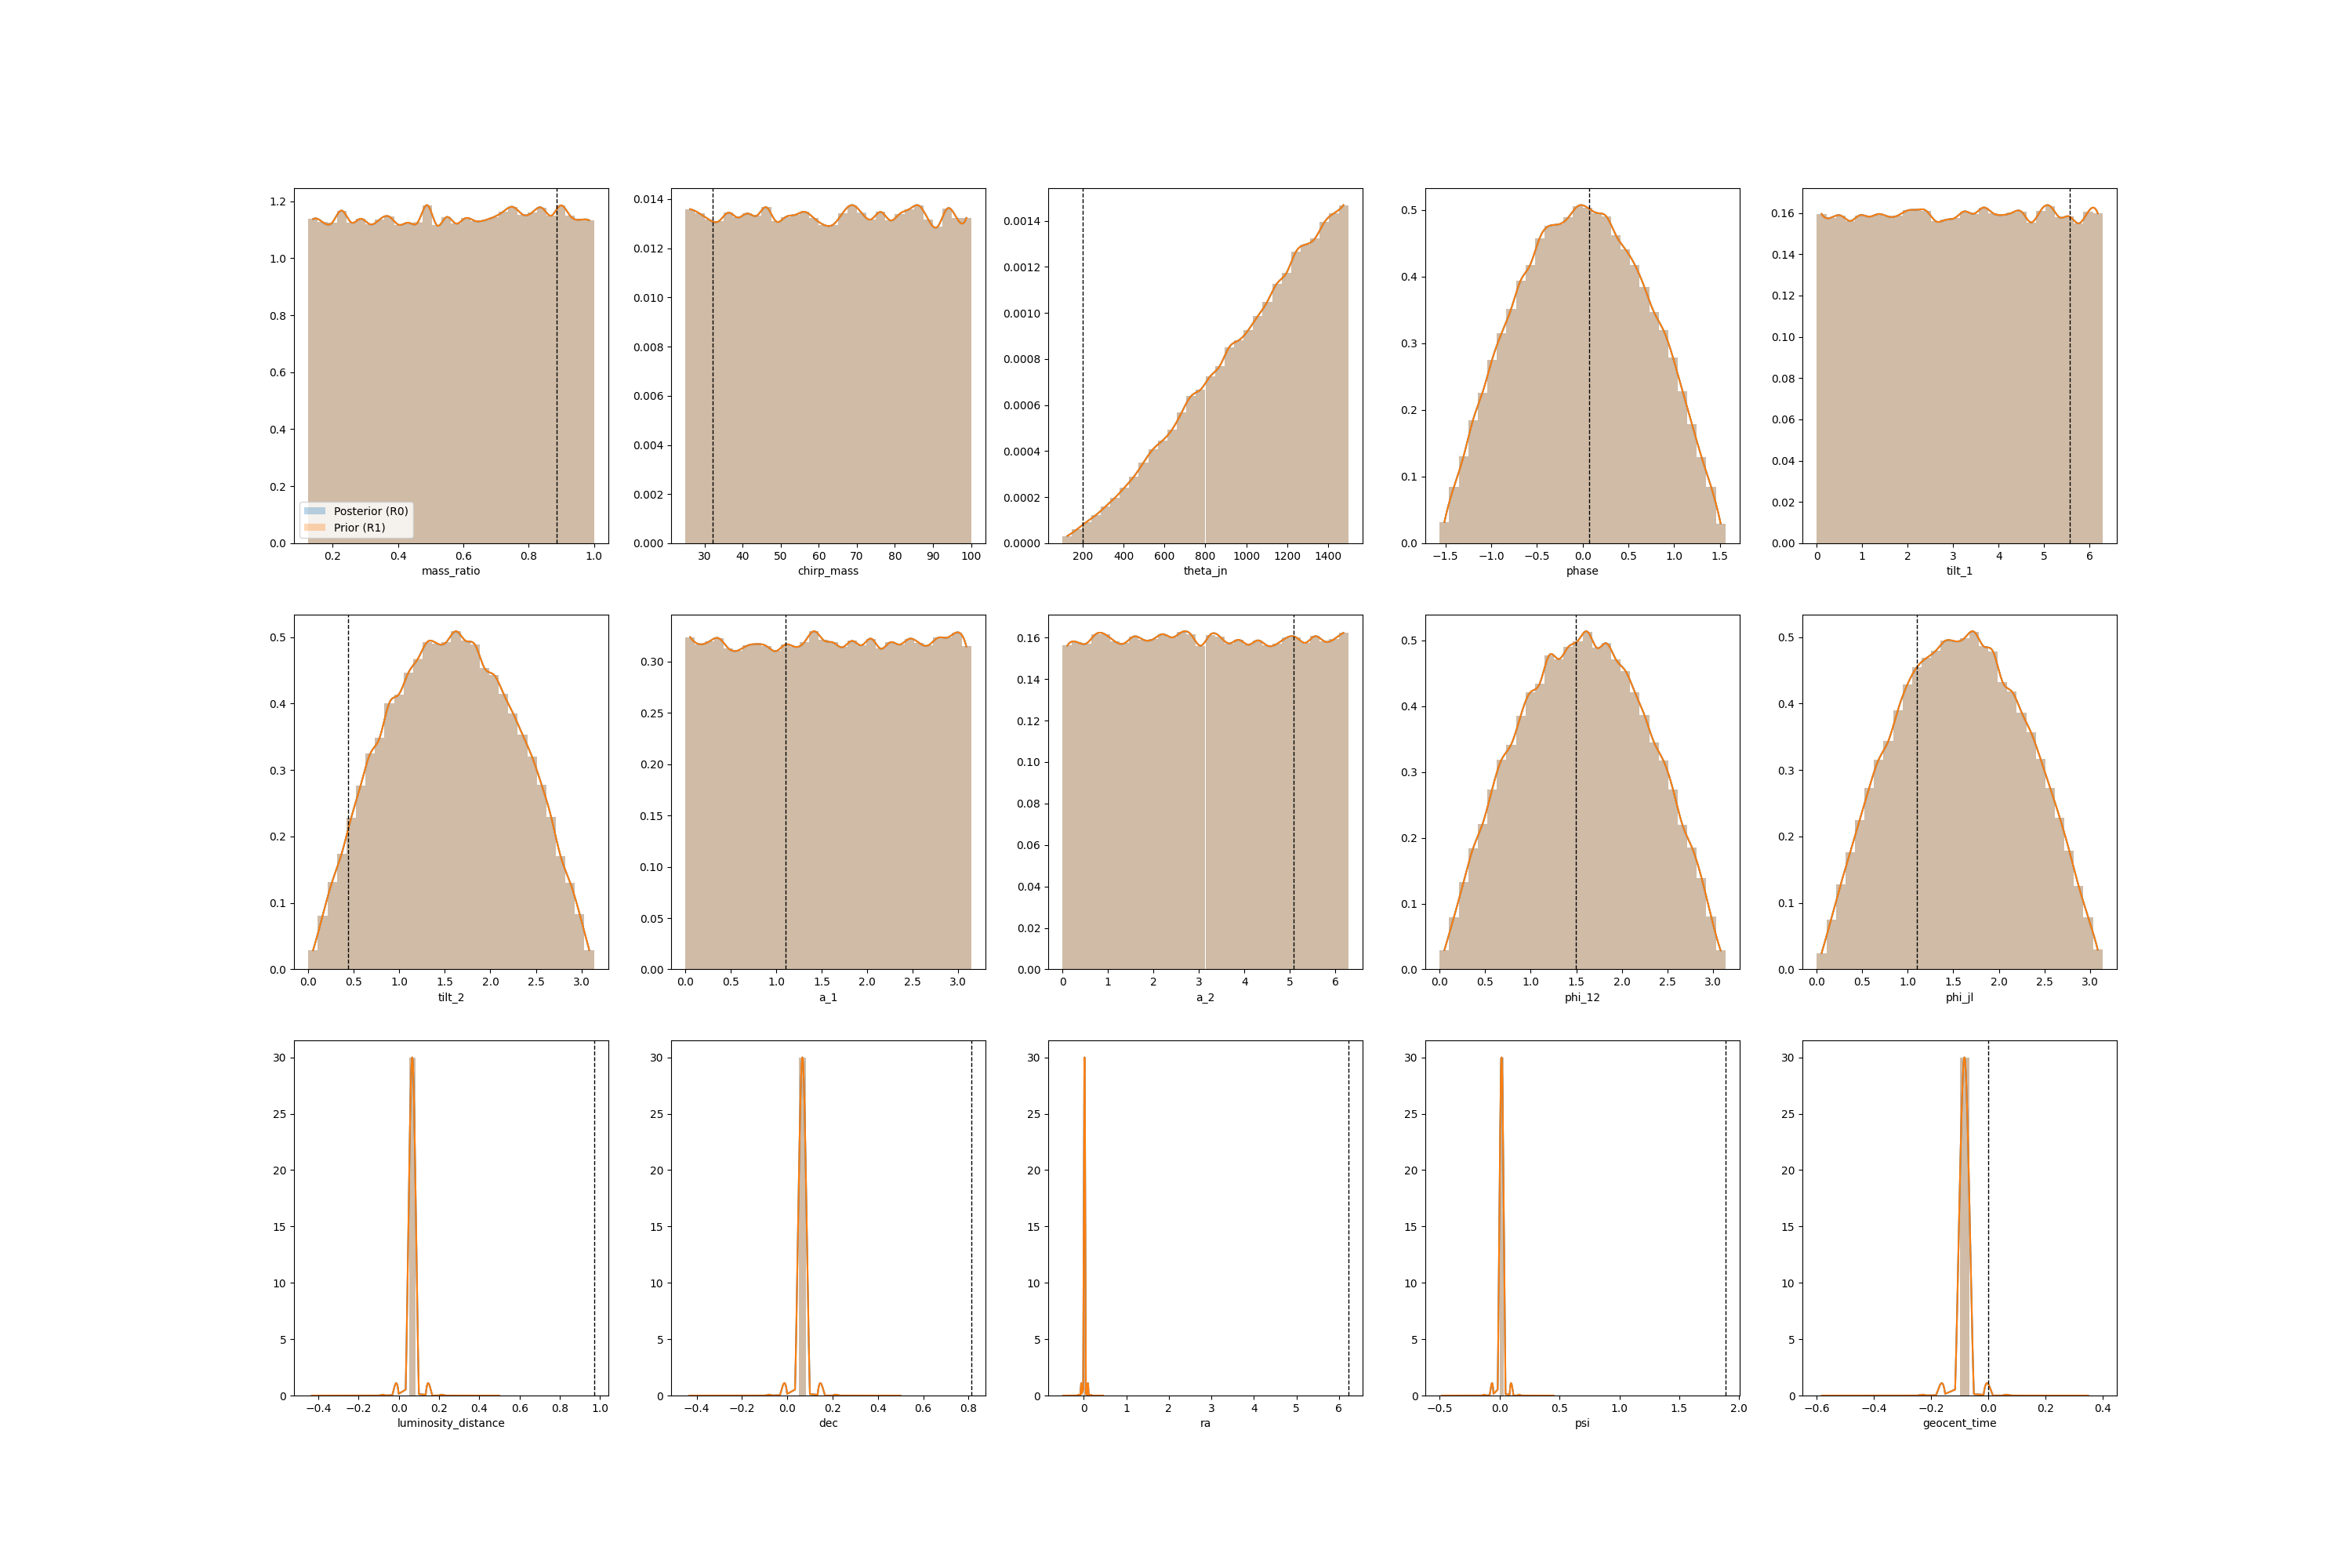

In [46]:
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib widget

parameter_names = pd.read_table(f'/scratch-shared/scur2012/peregrine_data/bhardwaj2023/param_idxs_highSNR.txt', 
                                sep = r'\s+', usecols=[0,1], header=None).set_index(1).values[:,0]
ground_truth = dict(zip(parameter_names, list(obs['z_int']) + list(obs['z_ext'])))

plt.figure(figsize=(30, 20))
for p_id in range(15):
    
    # Posteriors plot
    
    ax = plt.subplot(3, 5, p_id + 1)
    plt.xlabel(parameter_names[p_id])

    logratios = logratio_data.logratios[:, p_id]
    sample = logratio_data.params[:, p_id, 0]
    h, bins = np.histogram(
        sample, weights=np.exp(logratios), density=True, bins=30
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
        label=f'Posterior (R{round_id-1})',
    )
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=3, fill_value="extrapolate")

    x_grid = np.linspace(min1, max1, 1000)
    plt.plot(x_grid[fit1(x_grid)>0], fit1(x_grid)[fit1(x_grid)>0])
    
    # Priors plot
    
    sample = prior_samples['z_total'][:, p_id]
        
    h, bins = np.histogram(
        sample, density=True, bins=30
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
        label=f'Prior (R{round_id})',
    )
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=3, fill_value="extrapolate")
    
    if p_id == 0:
        plt.legend()
    x_grid = np.linspace(min1, max1, 1000)
    plt.plot(x_grid[fit1(x_grid)>0], fit1(x_grid)[fit1(x_grid)>0])
    
    # Add ground-truth
    plt.axvline(ground_truth[parameter_names[p_id]], 0, 1, color='k', linestyle='--', linewidth=1)

plt.show()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)